Reference:
/***************************************************************************************
*    Title: Hugging Face Transformers: Fine-tuning DistilBERT for Binary Classification Tasks
*    Author: Ray William
*    Date: 16 Feb 2021
*    Code version: 1.0
*    Availability: https://towardsdatascience.com/hugging-face-transformers-fine-tuning-distilbert-for-binary-classification-tasks-490f1d192379
*
*    Title: The Correct Way to Measure Inference Time of Deep Neural Networks
*    Author: Amnon Geifman
*    Date: 1 May 2023
*    Code version: 1.0
*    Availability: https://deci.ai/blog/measure-inference-time-deep-neural-networks/
*
*    ##dataset
*    Title: UtkMl's Twitter Spam Detection Competition
*    Author: UtkMl
*    Date: 27 Mar 2019
*    Code version: 1.0
*    Availability: https://www.kaggle.com/competitions/twitter-spam/overview
*
***************************************************************************************/

In [ ]:
!pip install transformers

In [ ]:
!pip install -U scikit-learn

In [ ]:
!pip install -U tensorboard_plugin_profile

In [ ]:
import tensorflow as tf
from tensorflow import keras
import pandas as pd
import numpy as np
import sys
from tensorflow.keras import layers
import matplotlib.pyplot as plt

In [ ]:
from google.colab import drive
drive.mount("/content/gdrive")

Mounted at /content/gdrive


In [ ]:
from transformers import TFAutoModelForSequenceClassification, TFAutoModel, AutoTokenizer, AutoConfig

In [ ]:
from transformers import TFAutoModelForSequenceClassification, TFAlbertModel, AlbertTokenizerFast, AlbertConfig

In [ ]:
train_data = pd.read_csv('/content/gdrive/My Drive/dataset/train.csv')
test_data = pd.read_csv('/content/gdrive/My Drive/dataset/test.csv')

In [ ]:
train_data.head()

In [ ]:
train_data.drop(['Id','following','followers','actions','is_retweet','location'], axis=1, inplace=True)
train_data['Type'] = train_data['Type'].replace({'Quality':0, 'Spam':1})

In [ ]:
train_data.head()

In [ ]:
train_data_shuffled = train_data.sample(frac=1)
train_data_shuffled.reset_index(inplace=True, drop=True)

In [ ]:
train_data_shuffled.head()

In [ ]:
train_data_shuffled.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11968 entries, 0 to 11967
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   Tweet   11968 non-null  object
 1   Type    11968 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 187.1+ KB


In [ ]:
print(
    "Total number of Spam and non-Spam tweets: "
    f"{train_data_shuffled.Type.value_counts()}"
      )

Total number of Spam and non-Spam tweets: 0    6153
1    5815
Name: Type, dtype: int64


In [ ]:
for index, example in train_data_shuffled[:5].iterrows():
    print(f"Example #{index}")
    print(f"\tType : {example['Type']}")
    print(f"\tTweet : {example['Tweet']}")

Example #0
	Type : 0
	Tweet : Retweeted Feargal McKay (@fmk_RoI):

A motor that even the UCI would be able to spot
http://www.irishtimes.com/business/geoorbital-inventing-the-wheel-of-fortune-1.2646877 …... http://fb.me/17ZO4Yxqa
Example #1
	Type : 1
	Tweet : #My2017BiggestHope my waist is smaller, my wallet is thicker, my mind is more peaceful 
Example #2
	Type : 0
	Tweet : Almost missed my stop falling asleep on the bus
Example #3
	Type : 0
	Tweet : Singlehttps://twitter.com/itszaym/status/617043686581530624 …
Example #4
	Type : 0
	Tweet : [TRANS] 160514 TWICE Fanacc 

Tzuyu's worst and best subject in school is ...?pic.twitter.com/NZjdFHySf4


In [ ]:
test_df = train_data_shuffled.sample(frac=0.1)
train_df = train_data_shuffled.drop(test_df.index)
valid_df = train_df.sample(frac=0.2)
train_df = train_df.drop(valid_df.index)
print(f"Using {len(train_df)} samples for training and {len(valid_df)} for validation and {len(test_df)} for testing")
print(train_df["Type"].value_counts())
print(valid_df["Type"].value_counts())
print(test_df["Type"].value_counts())

Using 8617 samples for training and 2154 for validation and 1197 for testing
0    4507
1    4110
Name: Type, dtype: int64
1    1092
0    1062
Name: Type, dtype: int64
1    613
0    584
Name: Type, dtype: int64


In [ ]:
X_train_df = train_df[['Tweet']]
Y_train_df = train_df[['Type']]
X_valid_df = valid_df[['Tweet']]
Y_valid_df = valid_df[['Type']]
X_test_df = test_df[['Tweet']]
Y_test_df = test_df[['Type']]

In [ ]:
print(X_train_df)
print(Y_train_df)
print(X_valid_df)
print(Y_valid_df)
print(X_test_df)
print(Y_test_df)

In [ ]:
MAX_LENGTH = 128
TF_DROPOUT = 0.25
TF_ATT_DROPOUT = 0.2
LAYER_DROPOUT = 0.2
LEARNING_RATE = 5e-5
RANDOM_STATE = 42
EPOCHS = 6
BATCH_SIZE = 64
FT_EPOCHS = 5

In [ ]:
tokenizer = AlbertTokenizerFast.from_pretrained('albert-base-v2')

def batch_encode(tokenizer, texts, batch_size=256, max_length=MAX_LENGTH):

    input_ids_list = []
    attention_mask_list = []

    for i in range(0, len(texts), batch_size):
        batch = texts[i:i+batch_size]
        inputs = tokenizer.batch_encode_plus(batch,
                                             max_length=max_length,
                                             padding='max_length',
                                             truncation=True,
                                             return_attention_mask=True,
                                             return_token_type_ids=False
                                             )
        input_ids_list.extend(inputs['input_ids'])
        attention_mask_list.extend(inputs['attention_mask'])


    return {
        'input_ids': tf.convert_to_tensor(input_ids_list),
        'attention_mask':tf.convert_to_tensor(attention_mask_list)
    }

X_train_encoded = batch_encode(tokenizer, X_train_df['Tweet'].tolist())

X_valid_encoded = batch_encode(tokenizer, X_valid_df['Tweet'].tolist())

X_test_encoded = batch_encode(tokenizer, X_test_df['Tweet'].tolist())

In [ ]:
print(X_train_encoded)

{'input_ids': <tf.Tensor: shape=(8617, 128), dtype=int32, numpy=
array([[    2,   547,    45, ...,     0,     0,     0],
       [    2,    31,  1376, ...,     0,     0,     0],
       [    2,  6926,   804, ...,     0,     0,     0],
       ...,
       [    2,  6926,  3904, ...,     0,     0,     0],
       [    2,   483, 21217, ...,     0,     0,     0],
       [    2,   636, 13405, ..., 12851,   263,     3]], dtype=int32)>, 'attention_mask': <tf.Tensor: shape=(8617, 128), dtype=int32, numpy=
array([[1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0, 0],
       ...,
       [1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 1, 1, 1]], dtype=int32)>}


In [ ]:
config = AlbertConfig.from_pretrained('albert-base-v2',
                                      dropout=TF_DROPOUT,
                                      attention_dropout=TF_ATT_DROPOUT,
                                      output_hidden_states=True)

TFModel = TFAlbertModel.from_pretrained('albert-base-v2', config=config)

for layer in TFModel.layers:
    layer.trainable = False

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFAlbertModel: ['predictions.decoder.bias', 'predictions.bias', 'predictions.dense.weight', 'predictions.dense.bias', 'predictions.LayerNorm.bias', 'predictions.LayerNorm.weight']
- This IS expected if you are initializing TFAlbertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFAlbertModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFAlbertModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFAlbertModel for predictions without further training.


In [ ]:
def build_model(transformer, max_length=MAX_LENGTH):
    """""""""
    Template for building a model off of the BERT or DistilBERT architecture
    for a binary classification task.

    Input:
      - transformer:  a base Hugging Face transformer model object (BERT or DistilBERT)
                      with no added classification head attached.
      - max_length:   integer controlling the maximum number of encoded tokens
                      in a given sequence.

    Output:
      - model:        a compiled tf.keras.Model with added classification layers
                      on top of the base pre-trained model architecture.
    """""""""

    weight_initializer = tf.keras.initializers.GlorotNormal(seed=RANDOM_STATE)

    input_ids_layer = tf.keras.layers.Input(shape=(max_length,),
                                            name='input_ids',
                                            dtype='int32')
    input_attention_layer = tf.keras.layers.Input(shape=(max_length,),
                                                  name='input_attention',
                                                  dtype='int32')

    last_hidden_state = transformer([input_ids_layer, input_attention_layer])[0]

    cls_token = last_hidden_state[:, 0, :]


    bi_lstm = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(units=128, return_sequences=True)
                                            )(tf.keras.layers.Reshape((1, -1))(cls_token))
    bi_lstm2 = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(units=128, return_sequences=True)
                                            )(bi_lstm)
    bi_lstm3 = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(units=128, return_sequences=True)
                                            )(bi_lstm2)
    bi_lstm4 = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(units=128, return_sequences=True)
                                            )(bi_lstm3)
    flat_bi_lstm = tf.keras.layers.Flatten()(bi_lstm4)

    dropout = tf.keras.layers.Dropout(rate=TF_DROPOUT)(flat_bi_lstm)

    dense = tf.keras.layers.Dense(units=128, activation='relu')(dropout)

    output = tf.keras.layers.Dense(1,
                                   activation='sigmoid',
                                   kernel_initializer=weight_initializer,
                                   kernel_constraint=None,
                                   bias_initializer='zeros'
                                   )(dense)

    model = tf.keras.Model([input_ids_layer, input_attention_layer], output)

    model.compile(tf.keras.optimizers.Adam(learning_rate=LEARNING_RATE),
                  loss="binary_crossentropy",
                  metrics=["Accuracy", "Recall", "Precision", "AUC"])

    return model

In [ ]:
model = build_model(TFModel)

In [ ]:
NUM_STEPS = len(X_train_df.index) // BATCH_SIZE

In [ ]:
print(NUM_STEPS)

134


In [ ]:
from datetime import datetime

In [ ]:
logs = "logs/" + datetime.now().strftime("%Y%m%d-%H%M%S")

In [ ]:
from keras.callbacks import EarlyStopping
early_stopping = EarlyStopping(monitor='val_loss', patience=1, verbose=1, mode = 'min', restore_best_weights=True)

In [ ]:
tboard_callback = tf.keras.callbacks.TensorBoard(log_dir = logs,
                                                 histogram_freq = 1,
                                                 update_freq = 'epoch')

In [ ]:
tf.profiler.experimental.start('logs/')
start2 = tf.timestamp()
train_history1 = model.fit(
    x = [X_train_encoded['input_ids'], X_train_encoded['attention_mask']],
    y = Y_train_df.to_numpy(),
    epochs = EPOCHS,
    batch_size = BATCH_SIZE,
    steps_per_epoch = NUM_STEPS,
    validation_data = ([X_valid_encoded['input_ids'], X_valid_encoded['attention_mask']], Y_valid_df.to_numpy()),
    verbose=2,
    callbacks= [early_stopping]
)
end2 = tf.timestamp()
tf.profiler.experimental.stop()
timings2 = end2 - start2
print(timings2)

Epoch 1/6
134/134 - 67s - loss: 0.6286 - Accuracy: 0.7344 - recall: 0.7335 - precision: 0.7171 - auc: 0.7749 - val_loss: 0.4535 - val_Accuracy: 0.7994 - val_recall: 0.7418 - val_precision: 0.8438 - val_auc: 0.8797 - 67s/epoch - 502ms/step
Epoch 2/6
134/134 - 34s - loss: 0.3619 - Accuracy: 0.8478 - recall: 0.8294 - precision: 0.8481 - auc: 0.9206 - val_loss: 0.3168 - val_Accuracy: 0.8672 - val_recall: 0.8498 - val_precision: 0.8838 - val_auc: 0.9404 - 34s/epoch - 255ms/step
Epoch 3/6
134/134 - 34s - loss: 0.2864 - Accuracy: 0.8810 - recall: 0.8741 - precision: 0.8758 - auc: 0.9502 - val_loss: 0.2792 - val_Accuracy: 0.8853 - val_recall: 0.8864 - val_precision: 0.8873 - val_auc: 0.9535 - 34s/epoch - 254ms/step
Epoch 4/6
134/134 - 34s - loss: 0.2455 - Accuracy: 0.9030 - recall: 0.9045 - precision: 0.8931 - auc: 0.9631 - val_loss: 0.2528 - val_Accuracy: 0.8979 - val_recall: 0.8974 - val_precision: 0.9007 - val_auc: 0.9614 - 34s/epoch - 256ms/step
Epoch 5/6
134/134 - 34s - loss: 0.2200 - Acc

In [ ]:
model.summary()

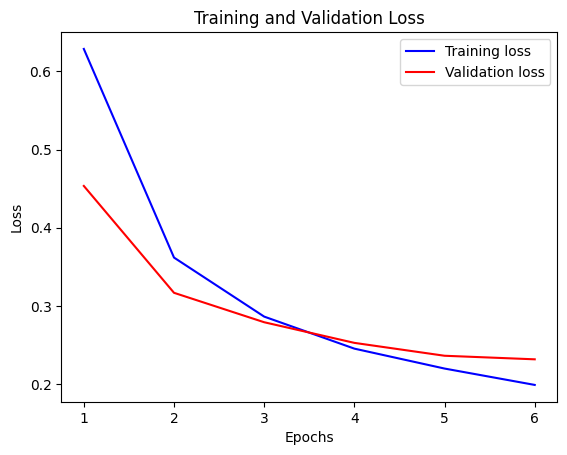

In [ ]:
# Extracting the history
training_loss = train_history1.history['loss']
validation_loss = train_history1.history['val_loss']

epochs = range(1, len(training_loss) + 1)
plt.plot(epochs, training_loss, 'b', label='Training loss')
plt.plot(epochs, validation_loss, 'r', label='Validation loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [ ]:
for layer in TFModel.layers:
    layer.trainable = True

model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=2e-5),
              loss="binary_crossentropy",
              metrics=["Accuracy", "Recall", "Precision", "AUC"])

tf.profiler.experimental.start('logs/')
start3 = tf.timestamp()
train_history2 = model.fit(
    x = [X_train_encoded['input_ids'], X_train_encoded['attention_mask']],
    y = Y_train_df.to_numpy(),
    epochs = FT_EPOCHS,
    batch_size = BATCH_SIZE,
    steps_per_epoch = NUM_STEPS,
    validation_data = ([X_valid_encoded['input_ids'], X_valid_encoded['attention_mask']], Y_valid_df.to_numpy()),
    verbose=2,
    callbacks= [early_stopping]
)
end3 = tf.timestamp()
tf.profiler.experimental.stop()
timings3= end3 - start3
print(timings3)

Epoch 1/5


134/134 - 111s - loss: 0.5807 - Accuracy: 0.6349 - recall: 0.2648 - precision: 0.8996 - auc: 0.7426 - val_loss: 0.6899 - val_Accuracy: 0.4930 - val_recall: 0.0000e+00 - val_precision: 0.0000e+00 - val_auc: 0.8204 - 111s/epoch - 830ms/step
Epoch 2/5
134/134 - 75s - loss: 0.2853 - Accuracy: 0.8530 - recall: 0.7570 - precision: 0.9210 - auc: 0.9541 - val_loss: 0.1305 - val_Accuracy: 0.9499 - val_recall: 0.9121 - val_precision: 0.9881 - val_auc: 0.9907 - 75s/epoch - 561ms/step
Epoch 3/5
134/134 - 75s - loss: 0.0884 - Accuracy: 0.9682 - recall: 0.9615 - precision: 0.9715 - auc: 0.9946 - val_loss: 0.1027 - val_Accuracy: 0.9670 - val_recall: 0.9551 - val_precision: 0.9793 - val_auc: 0.9945 - 75s/epoch - 561ms/step
Epoch 4/5
134/134 - 75s - loss: 0.0559 - Accuracy: 0.9802 - recall: 0.9759 - precision: 0.9824 - auc: 0.9978 - val_loss: 0.0959 - val_Accuracy: 0.9652 - val_recall: 0.9625 - val_precision: 0.9687 - val_auc: 0.9948 - 75s/epoch - 562ms/step
Epoch 5/5
Restoring model weights from the e

In [ ]:
model.summary()

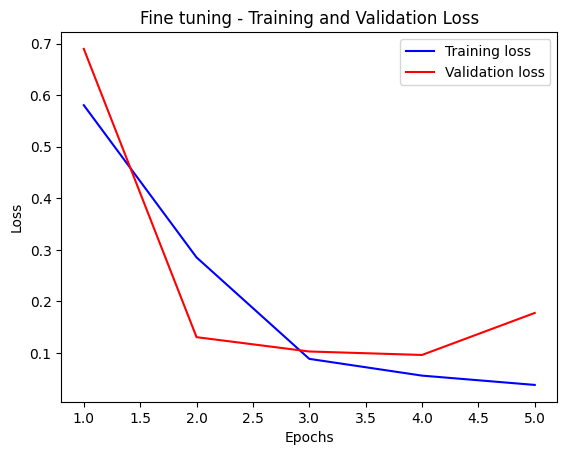

In [ ]:
training_loss2 = train_history2.history['loss']
validation_loss2 = train_history2.history['val_loss']

epochs = range(1, len(training_loss2) + 1)
plt.plot(epochs, training_loss2, 'b', label='Training loss')
plt.plot(epochs, validation_loss2, 'r', label='Validation loss')
plt.title('Fine tuning - Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [ ]:
from sklearn.metrics import classification_report

In [ ]:
from sklearn.metrics import f1_score, precision_score, recall_score, confusion_matrix

In [ ]:
y_pred = model.predict([X_test_encoded['input_ids'], X_test_encoded['attention_mask']], batch_size=128, verbose=1)
y_pred_class = (y_pred > 0.5).astype(int)
target_names = ['Ham','Spam']

print(classification_report(Y_test_df, y_pred_class,target_names=target_names,digits=4 ))

10/10 [==============================] - 9s 319ms/step
              precision    recall  f1-score   support

         Ham     0.9810    0.9743    0.9777       584
        Spam     0.9757    0.9821    0.9789       613

    accuracy                         0.9783      1197
   macro avg     0.9784    0.9782    0.9783      1197
weighted avg     0.9783    0.9783    0.9783      1197



In [ ]:
print(y_pred_class)

In [ ]:
print(y_pred)

In [ ]:
print('spam' if y_pred [0][0] > 0.5 else 'not spam')

not spam


In [ ]:
model.save('/content/gdrive/My Drive/model/Albert2/',overwrite=True)

In [ ]:
tf.config.run_functions_eagerly(True)

In [ ]:
testmodel = tf.saved_model.load('/content/gdrive/My Drive/model/Albert2/')

In [ ]:
tf.profiler.experimental.stop()

In [ ]:
testtokenizer = AlbertTokenizerFast.from_pretrained('albert-base-v2')
dummyinput = 'Obama Criminal Enterprise Collapsing  https://t.co/zIWjkQNMkh https://t.co/3gkxKiCqgP #TCOT #MAGA #PJNET https://t.co/ie8v1ORvAJ'

def encoder(tokenizer1, text, batch_size=256, max_length=128):
    input_ids_list = []
    attention_mask_list = []
    inputs = tokenizer1(text,
                        max_length=max_length,
                        padding='max_length',
                        truncation=True,
                        return_attention_mask=True,
                        return_token_type_ids=False
                        )

    input_ids_list.extend(inputs['input_ids'])
    attention_mask_list.extend(inputs['attention_mask'])

    input_ids_tensor = tf.convert_to_tensor(input_ids_list)
    input_ids_tensor = tf.reshape(input_ids_tensor, [1, max_length])
    attention_mask_tensor = tf.convert_to_tensor(attention_mask_list)
    attention_mask_tensor = tf.reshape(attention_mask_tensor, [1, max_length])
    return {
        'input_ids': input_ids_tensor,
        'attention_mask':attention_mask_tensor
    }

def classify_text(dummyinput):
    input = [dummyinput]
    X_predict_encoded = encoder(testtokenizer, dummyinput)
    output = model.predict([X_predict_encoded['input_ids'], X_predict_encoded['attention_mask']], batch_size=64, verbose=0)
    return output

for _ in range(10):
    _ = classify_text(dummyinput)

repetitions = 300
timings = np.zeros((repetitions, 1))

tf.profiler.experimental.start('logs/')
for rep in range(repetitions):
    start = tf.timestamp()
    testing123 = classify_text(dummyinput)
    end = tf.timestamp()
    timings[rep] = end - start
tf.profiler.experimental.stop()

mean_syn = np.sum(timings) / repetitions
std_syn = np.std(timings)
print(mean_syn*1000)
print(std_syn)

99.09916559855144
0.0057183018108307344


In [ ]:
print(sys.getsizeof(testmodel))

In [ ]:
%load_ext tensorboard

In [ ]:
%reload_ext tensorboard

In [ ]:
%tensorboard --logdir=logs

## Unused code